<a href="https://colab.research.google.com/github/milver/Experiments/blob/main/Barometric_Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Barometric Pressure Ecxtraction

In [1]:
import requests
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

In [2]:
# Function to fetch data from the API
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch data")
        return None



In [3]:
# Process the data
def process_data(json_data, start_time, end_time):
    local_tz = datetime.now().astimezone().tzinfo

    processed_data = []
    for record in json_data["historyData"]:
        utc_time = datetime.fromisoformat(record["startTime"].replace("Z", "+00:00"))
        local_time = utc_time.astimezone(local_tz)
        if start_time <= local_time <= end_time:
            pressure_inhg = record["values"]["pressureSeaLevel"]
            pressure_mbar = pressure_inhg * 33.8639
            processed_data.append({
                "startTime": local_time.strftime("%Y-%m-%dT%H:%M:%S"),
                "pressureSeaLevel_mbar": pressure_mbar
            })

    return processed_data



In [6]:
# Plotting function with migraine zone highlighting
def plot_data(processed_data):
    times = [datetime.fromisoformat(d['startTime']) for d in processed_data]
    pressures = [d['pressureSeaLevel_mbar'] for d in processed_data]
    rounded_times = [t.strftime('%a %-I%p') for t in times]

    plt.figure(figsize=(12, 7))
    plt.plot(rounded_times, pressures, marker='o', linestyle='-')
    plt.title('Pressure vs. Time with Migraine Zone Highlighted')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.grid(True)

    # Highlighting the migraine zone between 1003 and 1007 mbar
    plt.axhspan(1003, 1007, color='red', alpha=0.3)

    # Identifying times within the migraine zone
    for time, pressure in zip(rounded_times, pressures):
        if 1003 <= pressure <= 1007:
            plt.text(time, pressure, f'{time}', fontsize=9, ha='right')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

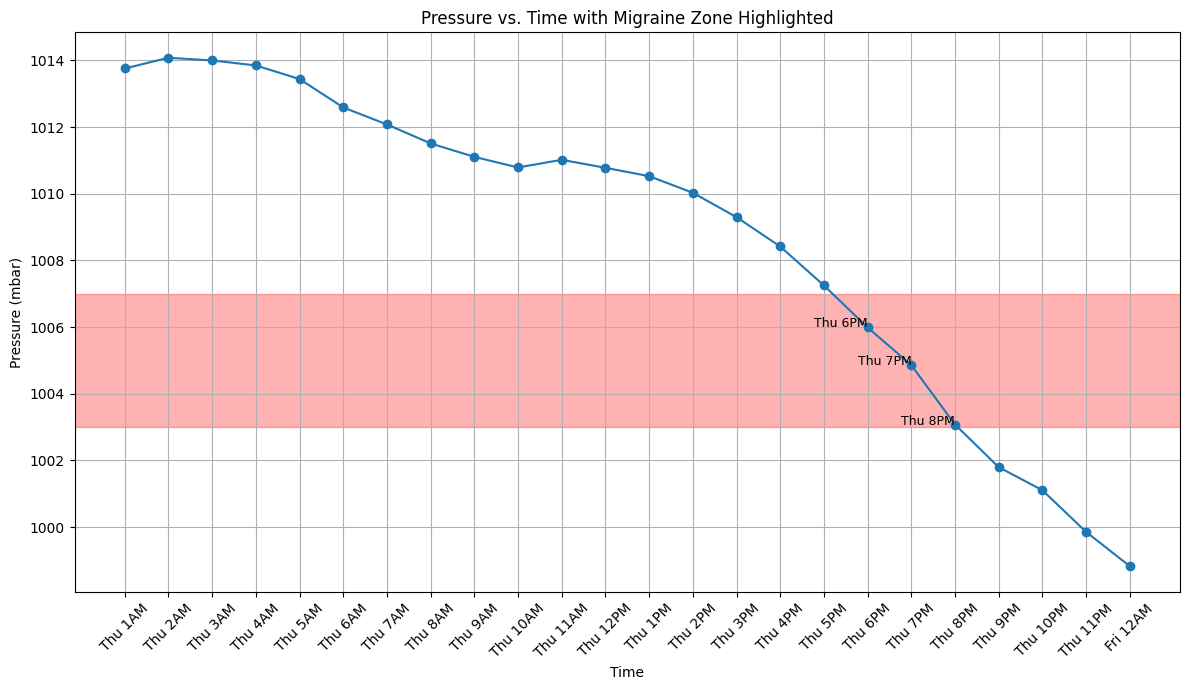

In [7]:
# URL to fetch data from
url = 'https://barometricpressure.app/api/timelineWk?lat=39.020834&lng=-77.50411'

# Fetch and process the data
json_data = fetch_data(url)
if json_data:
    current_time = datetime.now(pytz.utc)  # Ensure the current time is in UTC
    start_time_input = current_time - timedelta(hours=24)
    end_time_input = current_time
    processed_data = process_data(json_data, start_time_input, end_time_input)
    plot_data(processed_data)